In [654]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import tool
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState, StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage
# from langchain.agents import Agen

In [655]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")


In [656]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [657]:
tavily_search= TavilySearchResults()

In [658]:
@tool
def get_city_details(prompt):
    "Should do a web search to find the required city details"
    response = tavily_search.invoke(prompt)
    return response

In [659]:
# def entry_node(state: StockState):
#     # state["messages"] is List[BaseMessage]
#     last = state["messages"][-1]
#     question = last.content
#     return {"query": question}


In [660]:
# def get_stock_details(prompt:DefaultState):
#     """
#     Fetch detailed stock information for the given ticker symbol.

#     Args:
#         ticker (str): The stock ticker (e.g., "AAPL", "GOOG").

#     Returns:
#         dict: A dictionary containing price, volume, and other metrics.
#     """
#     # input = entry_node(prompt)
#     print("from stock prompt-------",prompt)
#     # print("from stock input-------",input)
#     "Should do a web search to find the required stock details"
#     response =tavily_search.invoke(prompt["messages"])
#     return response

In [ ]:
tools=[get_city_details]

In [662]:
model_with_tools=llm.bind_tools(tools)

In [663]:
# def get_stock_details(prompt):
#     "Should do a web search to find the required stock details"
#     response =tavily_search.invoke(prompt)
#     return response

In [664]:
class CityDetails(BaseModel):
    """Respond to the user with this"""
    state_name: str = Field(description="State name of the city")
    state_capital: str = Field(description="State capital of the city")
    country_name: str = Field(description="Country name of the city")
    country_capital: str = Field(description="Country capital of the city")

In [665]:
class DefaultResponse(BaseModel):
    """Respond to the user with this"""
    stock_name:str = Field(description="Write Stock Name ")
    stocke_price:str = Field(description="Write Stock Price")

In [666]:
# Inherit 'messages' key from MessagesState, which is a list of chat messages
class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: CityDetails

In [667]:
class DefaultState(MessagesState):
    # Final structured response from the agent
    final_response: DefaultResponse

In [668]:

model_with_structured_output = llm.with_structured_output(CityDetails)
model_with_llm_output= llm.with_structured_output(DefaultResponse)


In [766]:
def get_stock_details(prompt):
    """
    find ticker from the prompt then use it to pass in the search
    Fetch detailed stock information for the given ticker symbol.

    Args:
        ticker (str): The stock ticker 

    Returns:
        dict: A dictionary containing price, volume, and other metrics.
    """
    # input = entry_node(prompt)
    print("from stock prompt-------",prompt)
    # print("from stock input-------",input)
    "Should do a web search to find the required stock details"
    input=llm.invoke(prompt["messages"]).content
    print("from stock input-------",input)
    response =tavily_search.invoke(input)
    final_response = model_with_llm_output.invoke(response[0]["content"])
    print("from stock final_response-------",final_response)
    return {"final_response": final_response}
    # return response[0]["content"]

In [767]:
# get_stock_details({"messages":"What is the stock price of Tesla?"})

In [768]:
def call_model(state: AgentState):
    
    print(f"01 ____________ {state}")
    response = model_with_tools.invoke(state['messages'])
    print(f"02_______________{response}")
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [769]:
# model_with_structured_output= llm.with_structured_output(CityDetails)
# model_with_llm_output= llm.with_structured_output(DefaultResponse)

In [770]:
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    temp_check = messages[0].content.split(" ")
    if not last_message.tool_calls[0]["name"] == "get_city_details":
        return "continue"
    elif "stock" in temp_check:
        return "stock"
    else:
        return "respond"

In [771]:
def respond(state: AgentState):
    print(f"03 _____________ {state}")
    if "city" in state:
        response = model_with_structured_output.invoke([HumanMessage(content=state['messages'][-1].content)])
    else:
        response = model_with_llm_output.invoke([HumanMessage(content=state['messages'][-1].content)])
    # We return the final answer
    print(f"04_______________{response}")
    return {"final_response": response}
# def llm_response(state: AgentState):
#     print(f"05 _____________ {state}")
#     response = model_with_llm_output.invoke([HumanMessage(content=state['messages'][-1].content)])
#     # We return the final answer
#     print(f"06_______________{response}")
#     return {"final_response": response}

### WorkFlow

In [772]:

workflow = StateGraph(AgentState)


workflow.add_node("llm", call_model)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("respond", respond)
workflow.add_node("stock_response", get_stock_details)


workflow.set_entry_point("llm")

# We now add a conditional edge
workflow.add_conditional_edges(
    "llm",
    
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
        "stock": "stock_response",
    },
)

workflow.add_edge("tools", "llm")
workflow.add_edge("respond", END)
workflow.add_edge("stock_response", END)
graph = workflow.compile()

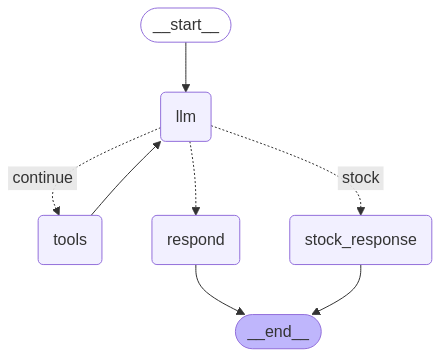

In [773]:
graph

In [774]:
# graph.invoke(input={"messages":[("human","What is the capital of delhi?")]})["final_response"]
answer = graph.invoke(input={"messages": [("human", "What is the stock price of the Tesla?")]})['final_response']

01 ____________ {'messages': [HumanMessage(content='What is the stock price of the Tesla?', additional_kwargs={}, response_metadata={}, id='a935ef99-936c-4809-b5dc-d58c494987d0')]}
02_______________content='' additional_kwargs={'tool_calls': [{'id': 'call_erea', 'function': {'arguments': '{"prompt":"What is the stock price of Tesla?"}', 'name': 'get_city_details'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 944, 'total_tokens': 1034, 'completion_time': 0.163636364, 'prompt_time': 0.033173415, 'queue_time': 0.23327542300000004, 'total_time': 0.196809779}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-bf0f7a1e-5f05-4c2e-983e-4669d19b9f73-0' tool_calls=[{'name': 'get_city_details', 'args': {'prompt': 'What is the stock price of Tesla?'}, 'id': 'call_erea', 'type': 'tool_call'}] usage_metadata={'input_tokens': 944, 'output_tokens': 90, 'total_tokens': 1034

In [775]:
answer

DefaultResponse(stock_name='Tesla', stocke_price='374.32')